In [1]:
!pip install hmmlearn
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 12.7 MB/s eta 0:00:00


In [2]:
import numpy as np
from hmmlearn import hmm

import matplotlib.pyplot as plt
import seaborn as sns

from skimage import exposure, feature
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from torchvision import datasets, transforms

In [3]:
# Preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('data', download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 19999317.30it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 373521.94it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6293595.09it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18743296.00it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



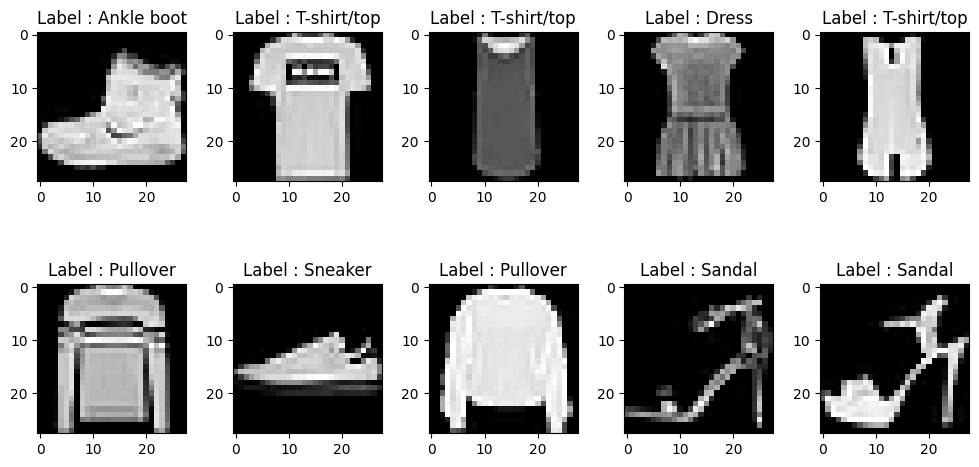

In [4]:
fig = plt.figure(figsize=(10,10))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(10):
    fig.add_subplot(4, 5, i+1)
    fig.tight_layout()
    plt.imshow(trainset.data[i].numpy(), cmap='gray')
    plt.title('Label : %s' % class_names[trainset.targets[i]])
plt.show()

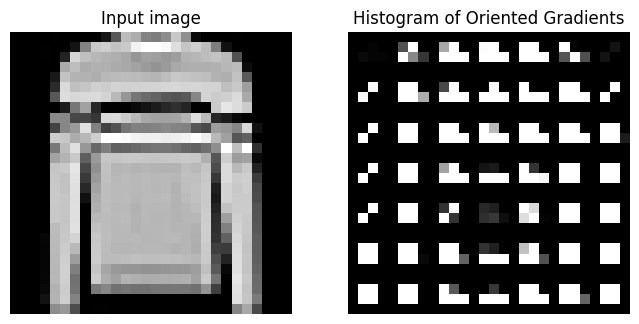

In [5]:
image = trainset.data[5].numpy()

fd, hog_image = feature.hog(image, orientations=9, pixels_per_cell=(4, 4), cells_per_block=(2, 2), block_norm="L2", visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [6]:
def HOG_img(img):
    features = feature.hog(img, orientations=9, pixels_per_cell=(4, 4),
                      cells_per_block=(2, 2), block_norm="L2")
    return features

In [7]:
X_train = trainset.data.numpy()
y_train = trainset.targets.numpy()
X_test = testset.data.numpy()
y_test = testset.targets.numpy()

In [8]:
train_HOG_ft = []
for index, img in enumerate(X_train):
    print('\rHOG: ' + str(round((index+1)/len(X_train)*100, 1)) + '%', end='')
    train_HOG_ft.append(HOG_img(img))
print('')

test_HOG_ft = []
for index, img in enumerate(X_test):
    print('\rHOG: ' + str(round((index+1)/len(X_test)*100, 1)) + '%', end='')
    test_HOG_ft.append(HOG_img(img))
print('')

HOG: 100.0%
HOG: 100.0%


In [9]:
X_train = np.array(train_HOG_ft).reshape(len(train_HOG_ft), -1)
X_test = np.array(test_HOG_ft).reshape(len(test_HOG_ft), -1)

# LDA to get feature vectors
lda = LinearDiscriminantAnalysis(n_components=9)  # n_components must be min(n_classes - 1, n_features)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

# One HMM per class
models = []
n_states = 1
for c in range(10):
    # Train HMM for class c
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="tied", n_iter=600)
    model.fit(X_train[y_train==c])
    models.append(model)

In [10]:
y_scores = []

for i in range(len(X_test)):
    obs = X_test[i]
    obs = obs.reshape(1, -1)  # Reshape to 2D
    scores = [model.score(obs) for model in models]
    y_scores.append(scores)

In [11]:
y_pred = [np.argmax(scores) for scores in y_scores]

In [12]:
# Accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy*100:.2f}%")

# Classification report
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy: 87.12%
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.81      0.82      1000
     Trouser       0.99      0.94      0.96      1000
    Pullover       0.82      0.81      0.81      1000
       Dress       0.83      0.87      0.85      1000
        Coat       0.79      0.82      0.81      1000
      Sandal       0.95      0.95      0.95      1000
       Shirt       0.67      0.65      0.66      1000
     Sneaker       0.92      0.94      0.93      1000
         Bag       0.94      0.98      0.96      1000
  Ankle boot       0.96      0.95      0.96      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



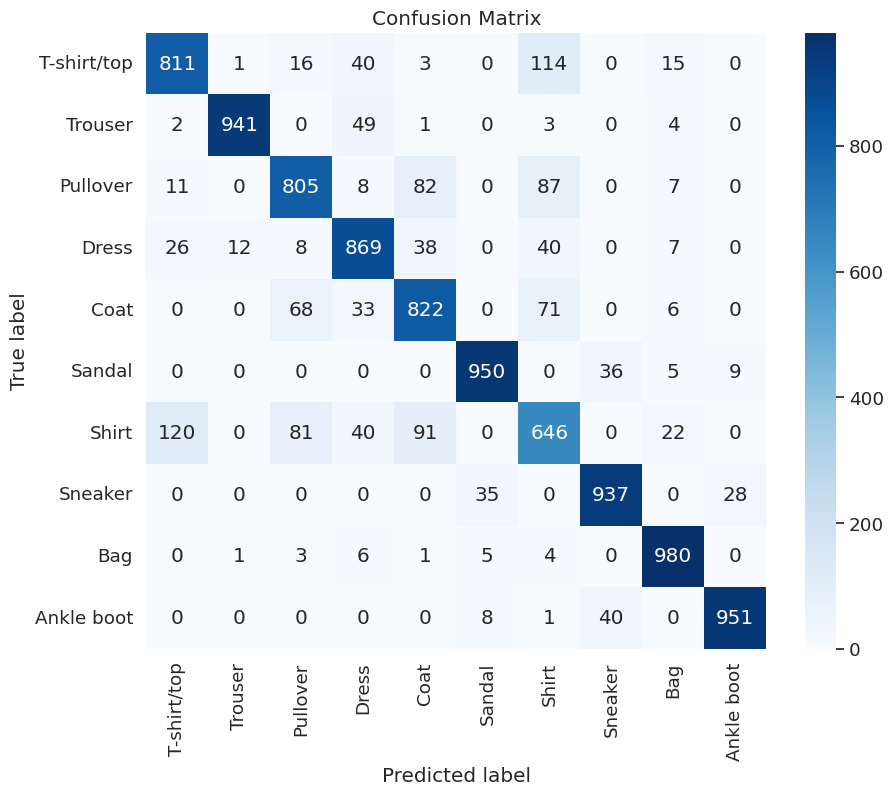

In [13]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')
plt.show()

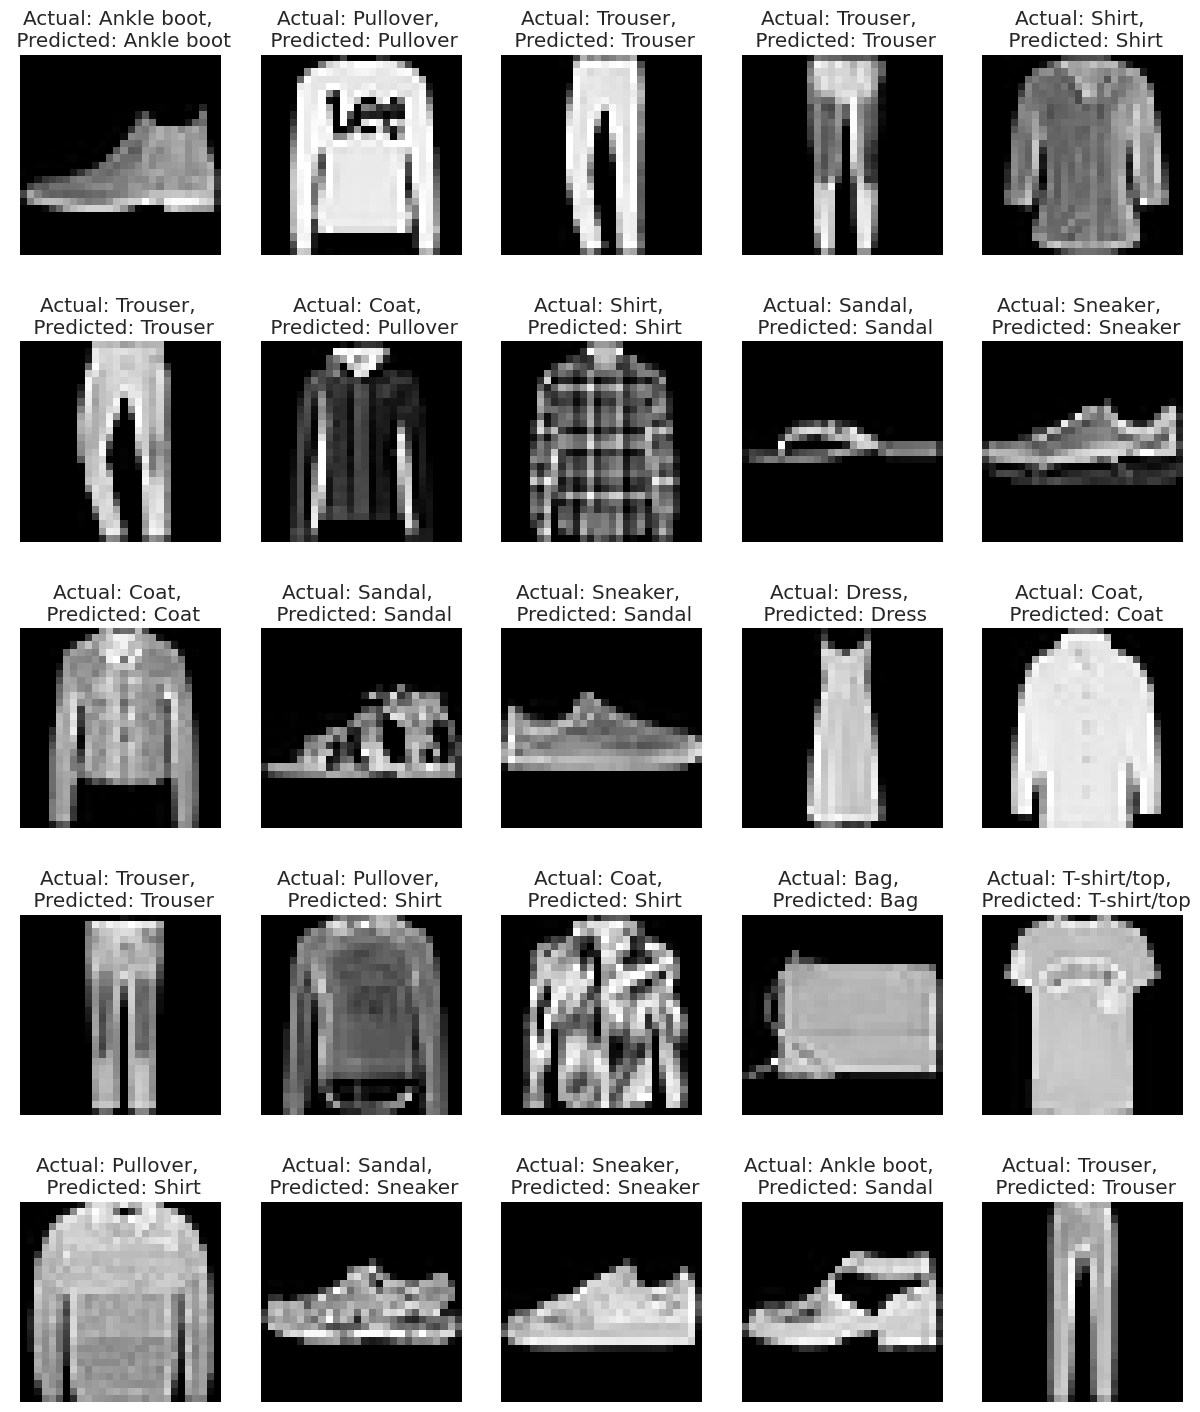

In [14]:
# Preprocessing
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.FashionMNIST('data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('data', download=True, train=False, transform=transform)

n_samples = 25  # Plot 25 samples
test_images = testset.data.numpy()

fig = plt.figure(figsize=(15,18))

for i in range(n_samples):
    fig.add_subplot(5, 5, i+1)  # Add subplot in 5x5 grid
    plt.imshow(test_images[i], cmap='gray')
    plt.title(f"Actual: {class_names[y_test[i]]}, \n Predicted: {class_names[int(y_pred[i])]}")
    plt.axis('off')
plt.show()

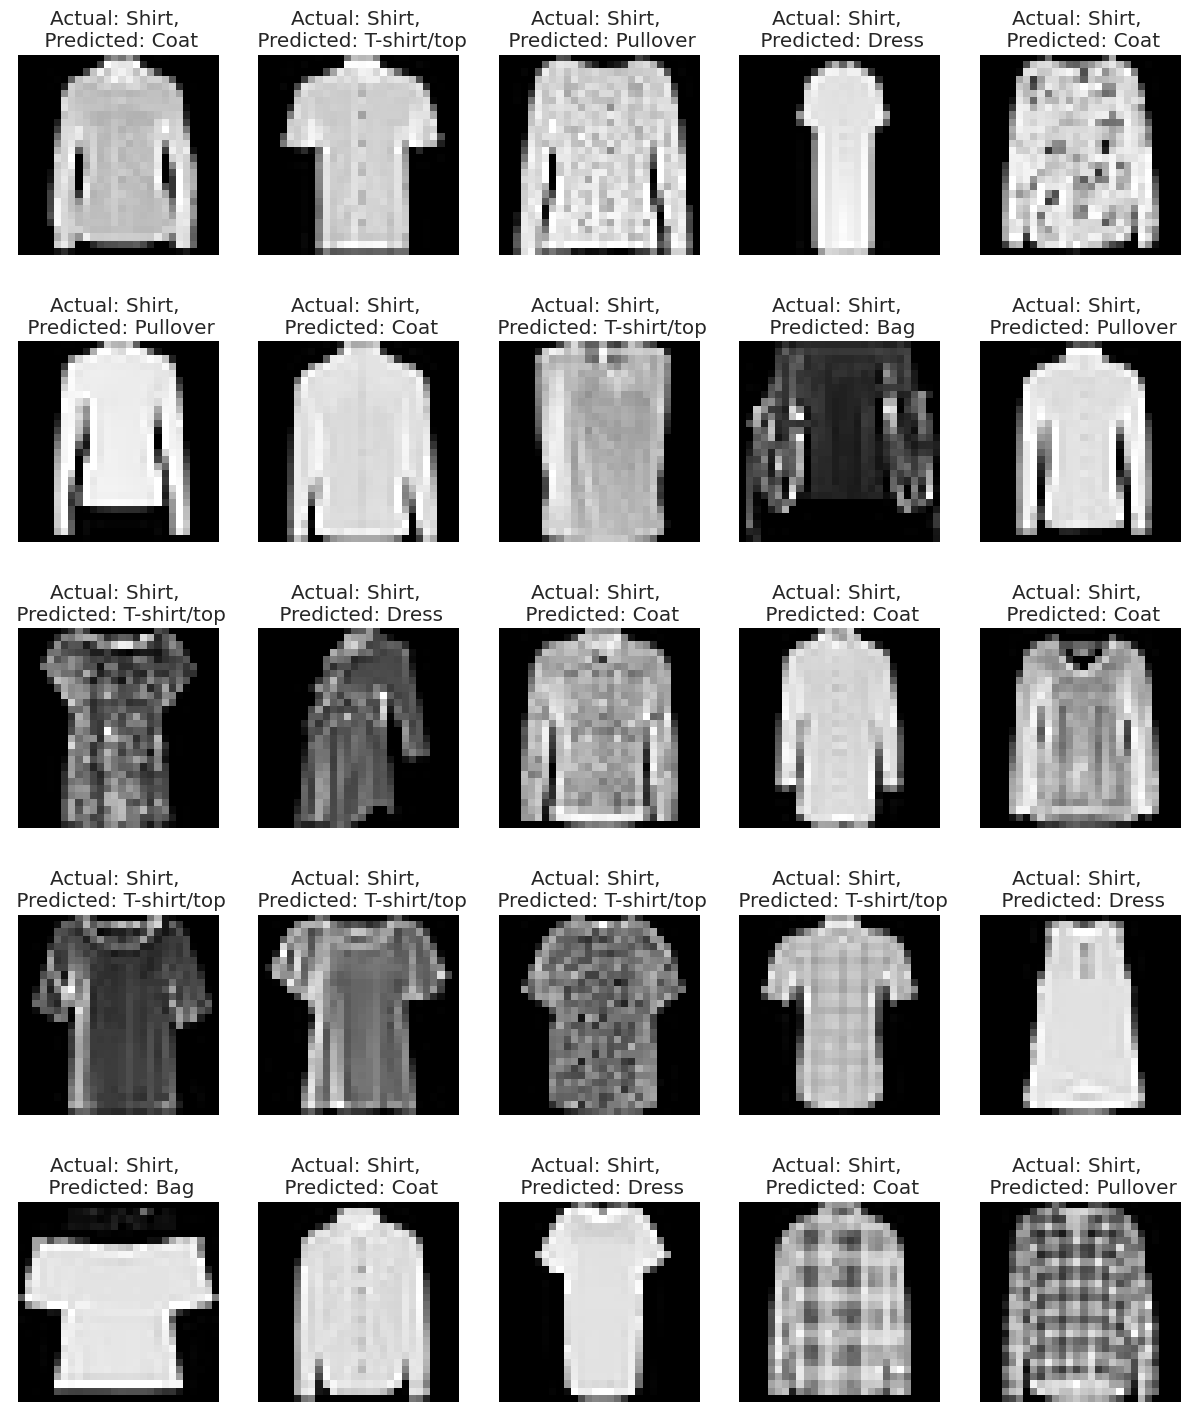

In [15]:
n_errors = 25  # Plot 25 incorrect predictions

errors = []
for i in range(len(y_test)):
    if y_test[i] != y_pred[i] and y_test[i] == 6:
        errors.append(i)  # Add index of incorrect prediction to errors

fig = plt.figure(figsize=(15,18))

for i in range(n_errors):
    index = errors[i]
    fig.add_subplot(5, 5, i+1)
    plt.imshow(test_images[index], cmap='gray')
    plt.title(f"Actual: {class_names[y_test[index]]}, \n Predicted: {class_names[int(y_pred[index])]}")
    plt.axis('off')
plt.show()

In [16]:
y_proba = [np.exp(score) / np.sum(np.exp(score)) for score in y_scores]

AUC: 0.9872648111111112 



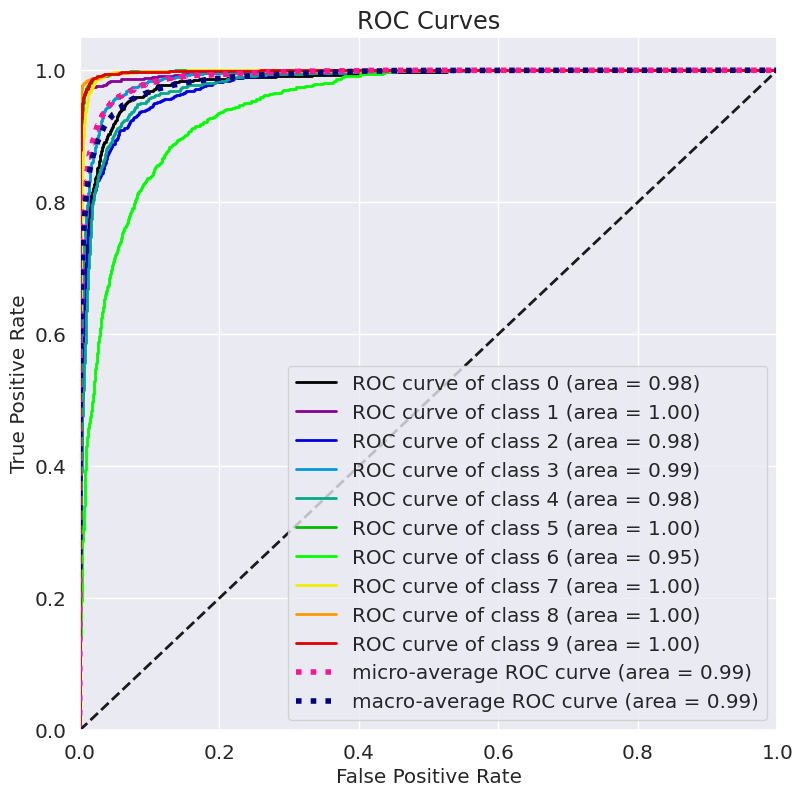

In [17]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_test, y_proba, figsize=(9, 9))
print('AUC:', roc_auc_score(y_test, y_proba, multi_class='ova'), '\n')

plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

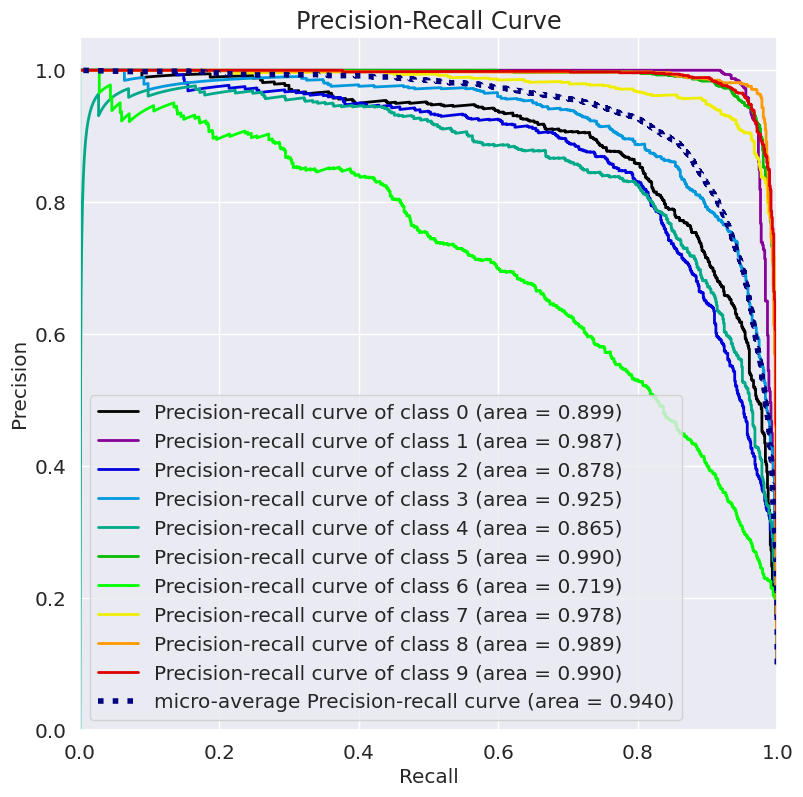

In [18]:
skplt.metrics.plot_precision_recall(y_test, y_proba, figsize=(9, 9))